In [22]:
from PIL import Image
import imageio
import numpy as np
from matplotlib.pyplot import imshow
import time

In [23]:
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random
import cv2
from math import log
from tqdm import tqdm
from PIL import Image
import urllib.request
import time

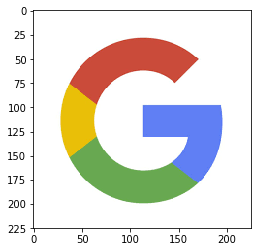

In [24]:
# ---------------Read Image to Encrypt---------------
img = imageio.imread('1.png')
imshow(img)
 
nl = l = img.shape[0]
nw = w = img.shape[1]
n = 50
if l % n:
    nl = (int((l - 1) / n) + 1) * n
if w % n:
    nw = (int((w - 1) / n) + 1) * n
img2 = np.zeros((nl, nw, 4))
img2[:l, :w, :] += img  # Making the picture to have square dimensions

In [25]:
start_time = time.time()
print(start_time)
# -------------Generating Encryption Key-------------
Mod = 256
k = 23  # Key for Encryption
 
# Arbitrary Matrix, should be saved as Key also
d = np.random.randint(256, size=(int(n/2), int(n/2)))
I = np.identity(int(n/2))
a = np.mod(-d, Mod)
 
b = np.mod((k * np.mod(I - a, Mod)), Mod)
k = np.mod(np.power(k, 127), Mod)
c = np.mod((I + a), Mod)
c = np.mod(c * k, Mod)
 
A1 = np.concatenate((a, b), axis=1)
A2 = np.concatenate((c, d), axis=1)
A = np.concatenate((A1, A2), axis=0)

1616492855.1752782


In [26]:
# making sure that A is an involutory matrix, A*A = I
Test = np.mod(np.matmul(np.mod(A, Mod), np.mod(A, Mod)), Mod)

In [27]:
# Saving key as an image
key = np.zeros((n + 1, n))
key[:n, :n] += A
# Adding the dimension of the original image within the key
# Elements of the matrix should be below 256
key[-1][0] = int(l / Mod)
key[-1][1] = l % Mod
key[-1][2] = int(w / Mod)
key[-1][3] = w % Mod
#imageio.imwrite("Key.png", key)

In [28]:
print("--- %s seconds ---" % (time.time() - start_time))
time_gen_enc_key = (time.time() - start_time)
start_time = time.time()
print(start_time)

--- 7.557938575744629 seconds ---
1616492862.7362068


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


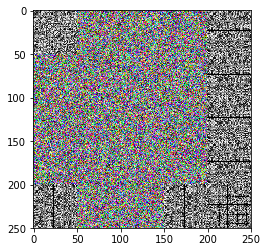

In [29]:
# -------------Encrypting-------------
Encrypted = np.zeros((nl, nw, 3))
for j in range(int(nw/n)):
    for i in range(int(nl/n)):
        Enc1 = (
            np.matmul(A % Mod, img2[i * n:(i + 1) * n, j * n:(j + 1) * n, 0] % Mod)) % Mod
        Enc1 = np.matmul(A % Mod, np.transpose(Enc1)) % Mod
        Enc2 = (
            np.matmul(A % Mod, img2[i * n:(i + 1) * n, j * n:(j + 1) * n, 1] % Mod)) % Mod
        Enc2 = np.matmul(A % Mod, np.transpose(Enc2)) % Mod
        Enc3 = (
            np.matmul(A % Mod, img2[i * n:(i + 1) * n, j * n:(j + 1) * n, 2] % Mod)) % Mod
        Enc3 = np.matmul(A % Mod, np.transpose(Enc3)) % Mod

        Enc1 = np.resize(Enc1, (Enc1.shape[0], Enc1.shape[1], 1))
        Enc2 = np.resize(Enc2, (Enc2.shape[0], Enc2.shape[1], 1))
        Enc3 = np.resize(Enc3, (Enc3.shape[0], Enc3.shape[1], 1))
        Encrypted[i * n:(i + 1) * n, j * n:(j + 1) *
                  n] += np.concatenate((Enc1, Enc2, Enc3), axis=2)  # Enc = A * image

imageio.imwrite('Encrypted.png', Encrypted)
imshow(imageio.imread('Encrypted.png'))

In [30]:
print("--- %s seconds ---" % (time.time() - start_time))
time_enc_hill = (time.time() - start_time)
start_time = time.time()
print(start_time)

--- 6.587284803390503 seconds ---
1616492869.326327


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


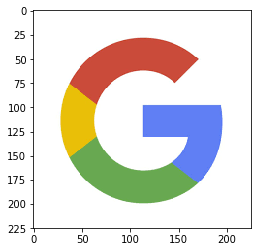

In [31]:
# -------------Decrypting-------------
Enc = imageio.imread('Encrypted.png')  # Reading Encrypted Image to Decrypt
nl = int(Enc.shape[0])
nw = int(Enc.shape[1])
# Loading the key
#A = imageio.imread('Key.png')
A = key
n = int(A.shape[0] - 1)
l = int(A[-1][0] * Mod + A[-1][1])  # The length of the original image
w = int(A[-1][2] * Mod + A[-1][3])  # The width of the original image
A = A[0:-1]

Decrypted = np.zeros((nl, nw, 3))
for j in range(int(nw/n)):
    for i in range(int(nl/n)):
        Dec1 = (np.matmul(A %
                          Mod, Enc[i * n:(i + 1) * n, j * n:(j + 1) * n, 0] % Mod)) % Mod
        Dec1 = np.matmul(A % Mod, np.transpose(Dec1)) % Mod
        Dec2 = (np.matmul(A %
                          Mod, Enc[i * n:(i + 1) * n, j * n:(j + 1) * n, 1] % Mod)) % Mod
        Dec2 = np.matmul(A % Mod, np.transpose(Dec2)) % Mod
        Dec3 = (np.matmul(A %
                          Mod, Enc[i * n:(i + 1) * n, j * n:(j + 1) * n, 2] % Mod)) % Mod
        Dec3 = np.matmul(A % Mod, np.transpose(Dec3)) % Mod

        Dec1 = np.resize(Dec1, (Dec1.shape[0], Dec1.shape[1], 1))
        Dec2 = np.resize(Dec2, (Dec2.shape[0], Dec2.shape[1], 1))
        Dec3 = np.resize(Dec3, (Dec3.shape[0], Dec3.shape[1], 1))
        Dec = np.concatenate((Dec1, Dec2, Dec3), axis=2)  # Dec = A * Enc
        Decrypted[i * n:(i + 1) * n, j * n:(j + 1) * n] += Dec

Final = Decrypted[:l, :w, :]  # Returning Dimensions to the real image

imageio.imwrite('Decrypted.png', Final)
imshow(imageio.imread('Decrypted.png'))

In [32]:
print("--- %s seconds ---" % (time.time() - start_time))
time_dec_hill = (time.time() - start_time)
print(start_time)

--- 4.886865139007568 seconds ---
1616492869.326327


In [33]:
print("time_gen_enc_key",time_gen_enc_key)
print("time_enc_hill",time_enc_hill)
print("time_dec_hill",time_dec_hill)

time_gen_enc_key 7.560928583145142
time_enc_hill 6.590120315551758
time_dec_hill 4.889935731887817


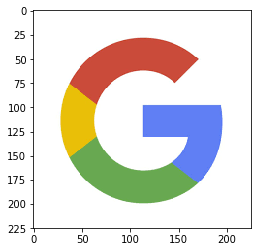

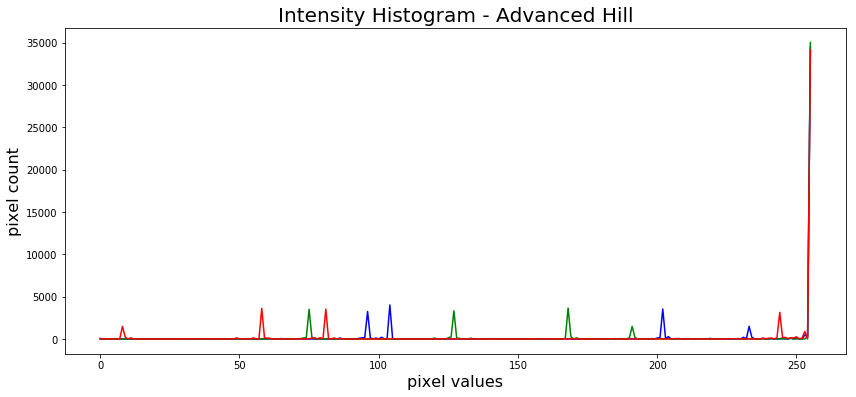

In [34]:
image = "1"
ext = ".png"
img = imageio.imread('1.png')
# pil_im = Image.open(image + ext, 'r')
imshow(np.asarray(img))

plt.figure(figsize=(14,6))
histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histogram_blue, color='blue') 
histogram_green = cv2.calcHist([img],[1],None,[256],[0,256]) 
plt.plot(histogram_green, color='green') 
histogram_red = cv2.calcHist([img],[2],None,[256],[0,256]) 
plt.plot(histogram_red, color='red') 
plt.title('Intensity Histogram - Advanced Hill', fontsize=20)
plt.xlabel('pixel values', fontsize=16)
plt.ylabel('pixel count', fontsize=16) 
plt.show()

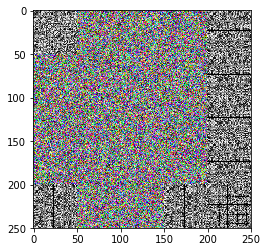

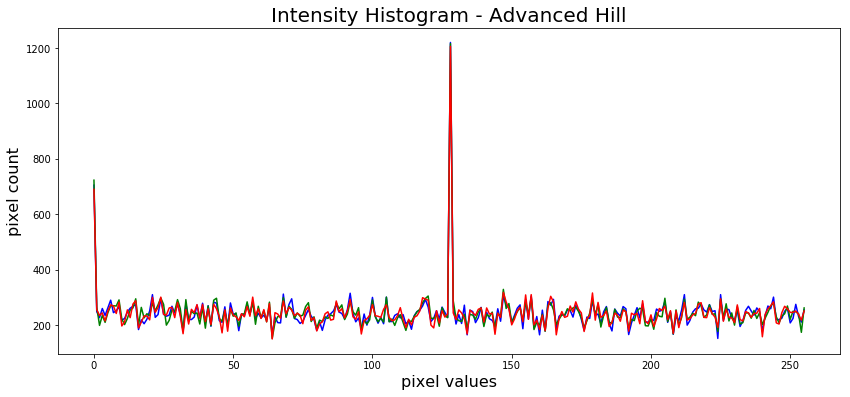

In [35]:
image = "Encrypted"
ext = ".png"
img = cv2.imread(image + ext,1) 
pil_im = Image.open(image + ext, 'r')
imshow(np.asarray(pil_im))

plt.figure(figsize=(14,6))
histogram_blue = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(histogram_blue, color='blue') 
histogram_green = cv2.calcHist([img],[1],None,[256],[0,256]) 
plt.plot(histogram_green, color='green') 
histogram_red = cv2.calcHist([img],[2],None,[256],[0,256]) 
plt.plot(histogram_red, color='red') 
plt.title('Intensity Histogram - Advanced Hill', fontsize=20)
plt.xlabel('pixel values', fontsize=16)
plt.ylabel('pixel count', fontsize=16) 
plt.show()

In [36]:
def getImageMatrix_gray(imageName):
    im = Image.open(imageName).convert('LA')
    pix = im.load()
    image_size = im.size 
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix,image_size[0]

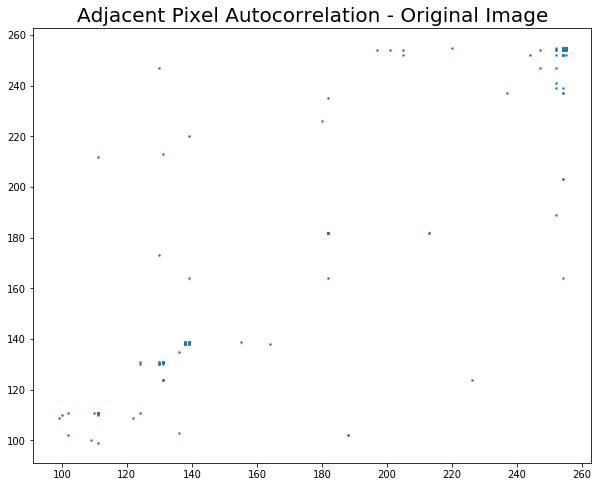

In [37]:
image = "1"
ext = ".png"
ImageMatrix,image_size = getImageMatrix_gray(image+ext)
samples_x = []
samples_y = []
for i in range(1024):
  x = random.randint(0,image_size-2)
  y = random.randint(0,image_size-1)
  samples_x.append(ImageMatrix[x][y])
  samples_y.append(ImageMatrix[x+1][y])
plt.figure(figsize=(10,8))
plt.scatter(samples_x,samples_y,s=2)
plt.title('Adjacent Pixel Autocorrelation - Original Image', fontsize=20)
plt.show()


250


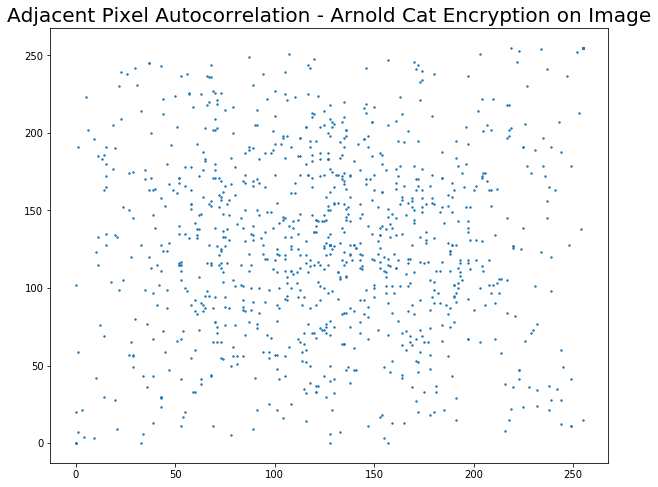

In [38]:
image = "Encrypted"
ext = ".png"
ImageMatrix,image_size = getImageMatrix_gray(image+ext)
samples_x = []
samples_y = []
print(image_size)
for i in range(1024):
  x = random.randint(0,image_size-2)
  y = random.randint(0,image_size-1)
  samples_x.append(ImageMatrix[x][y])
  samples_y.append(ImageMatrix[x+1][y])
plt.figure(figsize=(10,8))
plt.scatter(samples_x,samples_y,s=2)
plt.title('Adjacent Pixel Autocorrelation - Arnold Cat Encryption on Image', fontsize=20)
plt.show()